<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/Updated_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import plotly.express as px
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


In [3]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

In [4]:
# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']
categorical_columns = ['Depression', 'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications',
                       'Use_of_Corticosteroids', 'Sex']

In [5]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7000, 14), (1500, 14), (1500, 14), (7000, 1), (1500, 1), (1500, 1))

In [6]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

In [7]:
# Check multicollinearity
# VIF dataframe
X_train_filled_mice_df = pd.DataFrame(X_train_filled_mice)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_filled_mice_df.columns


# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_filled_mice_df.values, i)
                          for i in range(len(X_train_filled_mice_df.columns))]

print(vif_data)
# All good after removing LDL and HDL

    feature       VIF
0         0  1.220620
1         1  1.122415
2         2  1.118326
3         3  2.546792
4         4  1.254313
5         5  2.612574
6         6  1.285354
7         7  1.332063
8         8  4.562149
9         9  1.569685
10       10  1.148996
11       11  4.905079
12       12  1.447272
13       13  1.999843


In [8]:
# take a look at training X
for col in X.columns:
    print(col)

Age_at_Exam
sBP
BMI
A1c
TG
FBS
Total_Cholesterol
Depression
HTN
OA
COPD
Use_of_Hypertension_Medications
Use_of_Corticosteroids
Sex


# Research question 1

In [9]:
# Define utility functions for model evaluation

def get_scores(Y, Y_pred):
    """
    Computes various evaluation metrics for model predictions.

    Parameters:
    - Y: Actual target values.
    - Y_pred: Predicted target values by the model.

    Returns:
    - conf_matrix: Confusion matrix showing true positives, true negatives, false positives, and false negatives.
    - class_report: Classification report detailing precision, recall, and F1-score for each class.
    - auc: Area Under the Curve (AUC) value for the model's predictions.
    - acc: Accuracy of the model's predictions.
    """
    conf_matrix = confusion_matrix(Y, Y_pred)
    class_report = classification_report(Y, Y_pred)
    auc = roc_auc_score(Y, Y_pred)
    acc = accuracy_score(Y, Y_pred)

    return conf_matrix, class_report, auc, acc

def print_scores(conf_matrix, class_report, auc, acc):
    """
    Prints the evaluation metrics in a structured format.

    Parameters:
    - conf_matrix: Confusion matrix from get_scores function.
    - class_report: Classification report from get_scores function.
    - auc: AUC value from get_scores function.
    - acc: Accuracy value from get_scores function.
    """
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

K-Nearest Neighbour

In [10]:
# Find the best K using Cross Validation

k_values = [i for i in range (1,100)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_val_filled_mice, y_val, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

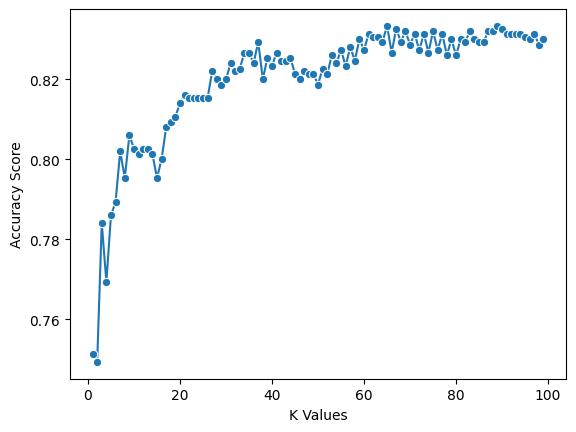

In [11]:
# Overall graph
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

(30.0, 40.0)

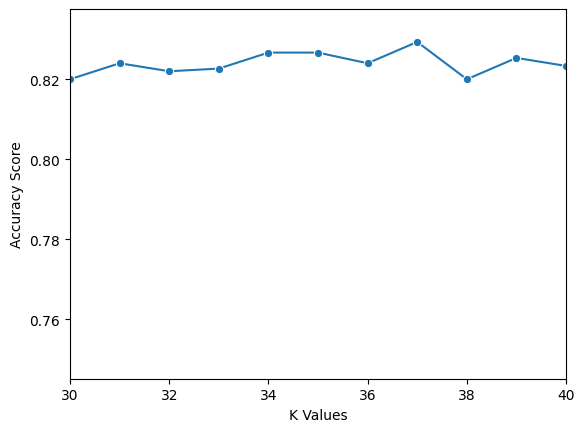

In [12]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xlim(30,40)

# K=37

(55.0, 70.0)

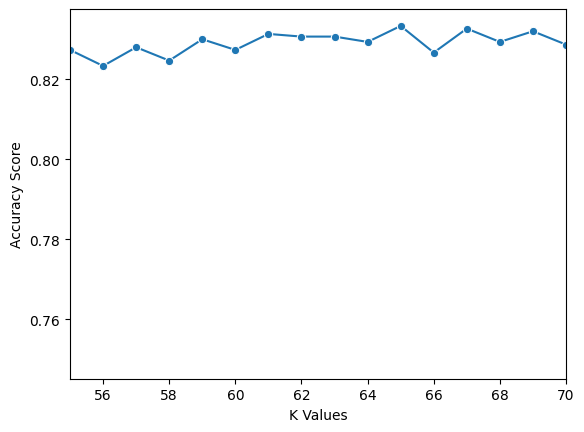

In [13]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xlim(55,70)

# K=65 does not improve accuracy that much

In [14]:
# Apply the KNN
knn = KNeighborsClassifier(n_neighbors=37)
knn.fit(X_train_filled_mice, y_train)

# Make predictions on the test and training sets
y_pred_test = knn.predict(X_test_filled_mice)
y_pred_train = knn.predict(X_train_filled_mice)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.8571230133949864
Accuracy :  0.8547142857142858
Confusion Matrix:
[[3043  675]
 [ 342 2940]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3718
           1       0.81      0.90      0.85      3282

    accuracy                           0.85      7000
   macro avg       0.86      0.86      0.85      7000
weighted avg       0.86      0.85      0.85      7000

======== Test Set ==========
AUC :  0.8465915207889241
Accuracy :  0.8433333333333334
Confusion Matrix:
[[668 154]
 [ 81 597]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       822
           1       0.79      0.88      0.84       678

    accuracy                           0.84      1500
   macro avg       0.84      0.85      0.84      1500
weighted avg       0.85      0.84      0.84      1500



Mixing models

In [15]:
### ML pipeline: raw -> cv -> split -> normalization -> imputation

# Splitting the original dataset into training, validation, and test sets

# Taking 70% of the data for training
train_df = df.sample(frac = 0.7)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = df.drop(train_df.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_df = test_df.sample(frac = 0.5)
test_df = test_df.drop(valid_df.index)

### We do not need to normalize the data for fitting a naive bayes model as normalization will change the distribution of the data.

# # Normalizing data
# scaler = StandardScaler()

# train_df_scaled = scaler.fit_transform(train_df)
# valid_df_scaled = scaler.fit_transform(valid_df)
# test_df_scaled = scaler.fit_transform(test_df)

train_mice = train_df.copy()
valid_mice = valid_df.copy()
test_mice = test_df.copy()

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
train_mice[numerical_columns] = imputer.fit_transform(train_df[numerical_columns])
valid_mice[numerical_columns] = imputer.fit_transform(valid_df[numerical_columns])
test_mice[numerical_columns] = imputer.fit_transform(test_df[numerical_columns])

column_names = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']

train_mice = pd.DataFrame(train_mice, columns=column_names)
valid_mice = pd.DataFrame(valid_mice, columns=column_names)
test_mice = pd.DataFrame(test_mice, columns=column_names)

In [16]:
test_df

,Age_at_Exam,sBP,BMI,A1c,TG,FBS,Total_Cholesterol,Depression,HTN,OA,COPD,Use_of_Hypertension_Medications,Use_of_Corticosteroids,Sex,DIABETES
8,70,123.0,33.000000,5.4,1.13,5.4,4.15,1,1,0,0,1,0,1,0
17,49,205.0,49.000000,6.0,0.63,5.2,7.12,0,1,0,0,1,0,1,0
23,60,128.0,29.000000,6.0,2.37,5.2,5.21,1,1,0,1,1,0,1,0
27,47,114.0,32.000000,6.2,0.75,4.6,4.97,0,1,0,0,1,0,1,0
28,54,148.0,34.000000,5.5,1.00,4.8,NaN,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9973,66,134.0,34.550000,6.2,0.58,6.1,2.81,0,1,1,0,1,0,1,1
9974,57,152.0,24.491901,7.1,2.29,7.5,6.61,0,1,0,0,1,0,0,1
9977,68,122.0,26.670000,7.0,1.08,7.4,NaN,1,0,1,0,0,0,1,1
9978,70,140.0,29.110000,7.5,1.74,10.9,4.07,0,1,1,0,1,0,0,1


AUC :  0.8498848842481435
Accuracy :  0.8481428571428572
Confusion Matrix:
[[3077  316]
 [ 747 2860]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      3393
           1       0.90      0.79      0.84      3607

    accuracy                           0.85      7000
   macro avg       0.85      0.85      0.85      7000
weighted avg       0.85      0.85      0.85      7000



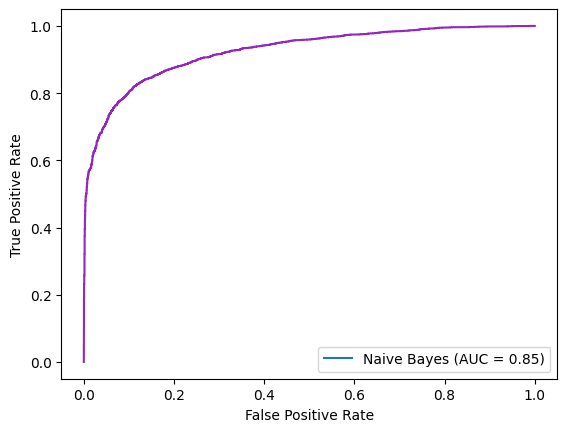

In [17]:
target_column = 'DIABETES'

# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB()
gnb = gnb.fit(train_mice[numerical_columns].to_numpy(), train_mice[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB()
cnb = cnb.fit(train_mice[categorical_columns].to_numpy(), train_mice[target_column])


# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(train_mice[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(train_mice[categorical_columns])


# Combine the log probabilities, adjusting for the multiplication of P(Y) term
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(train_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

AUC :  0.8421295629106552
Accuracy :  0.8406666666666667
Confusion Matrix:
[[652  77]
 [162 609]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       729
           1       0.89      0.79      0.84       771

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.85      0.84      0.84      1500



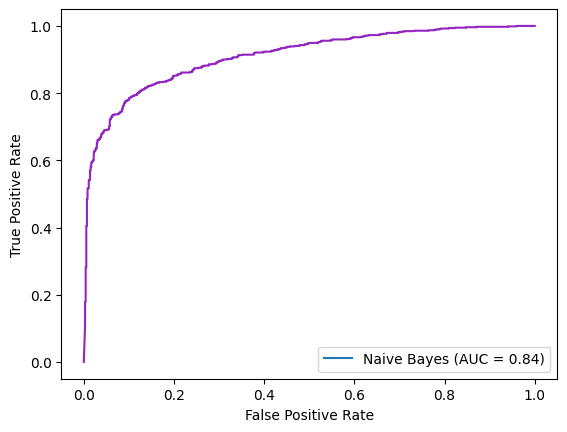

In [18]:
# Testing on validation set



# Predict the joint log probabilities for each model on validation data
gnb_log_pred = gnb.predict_joint_log_proba(valid_mice[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(valid_mice[categorical_columns])

# Combine the log probabilities, adjusting for the multiplication of P(Y) term
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels for validation data
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model on validation data using custom functions
conf_matrix, class_report, auc, acc = get_scores(valid_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(valid_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

AUC :  0.8440331164570513
Accuracy :  0.8433333333333334
Confusion Matrix:
[[659  80]
 [155 606]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       739
           1       0.88      0.80      0.84       761

    accuracy                           0.84      1500
   macro avg       0.85      0.84      0.84      1500
weighted avg       0.85      0.84      0.84      1500



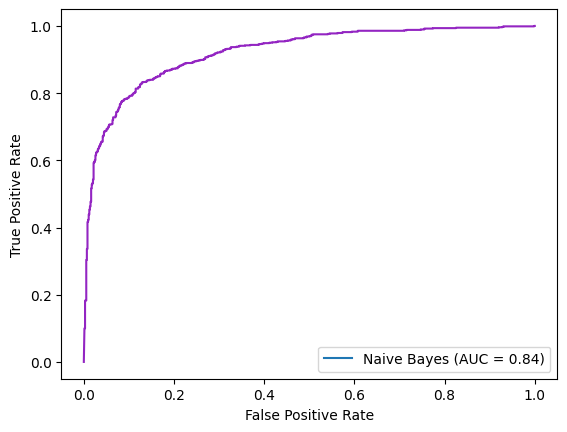

In [19]:
## Testing on test set


# Predict the joint log probabilities for each model on validation data
gnb_log_pred = gnb.predict_joint_log_proba(test_mice[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(test_mice[categorical_columns])

# Combine the log probabilities, adjusting for the multiplication of P(Y) term
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels for validation data
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model on validation data using custom functions
conf_matrix, class_report, auc, acc = get_scores(test_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(test_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Linear/Quadratic Discriminant Analysis (LDA) & (QDA) on Training Data

AUC :  0.8378199347292014
Accuracy :  0.8362857142857143
Confusion Matrix:
[[3013  380]
 [ 766 2841]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      3393
           1       0.88      0.79      0.83      3607

    accuracy                           0.84      7000
   macro avg       0.84      0.84      0.84      7000
weighted avg       0.84      0.84      0.84      7000



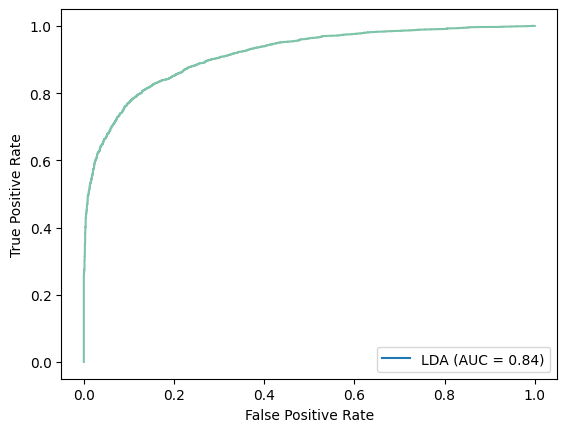

In [20]:
# Initialize the LDA model
model = LinearDiscriminantAnalysis()

# Train the model using the numerical columns from the training data
model = model.fit(train_mice[numerical_columns], train_mice[target_column])

# Predict the class labels and probabilities for the training data
y_hat = model.predict(train_mice[numerical_columns]) # Predicted class labels
y_hat_prob = model.predict_proba(train_mice[numerical_columns]) # Probability estimates for each class

# Evaluate the model's performance on the training data
conf_matrix, class_report, auc, acc = get_scores(train_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Visualize the ROC curve for better understanding of the model's performance
fpr, tpr, thresholds = roc_curve(train_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='LDA') # Note the name change to LDA from Naive Bayes
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#7ec4a9')

AUC :  0.8396283187445964
Accuracy :  0.8374285714285714
Confusion Matrix:
[[3093  300]
 [ 838 2769]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      3393
           1       0.90      0.77      0.83      3607

    accuracy                           0.84      7000
   macro avg       0.84      0.84      0.84      7000
weighted avg       0.85      0.84      0.84      7000



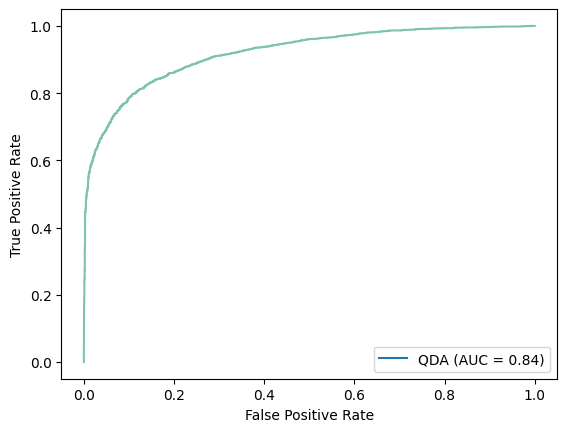

In [21]:
# Training the QDA model on numerical columns of the training data
m = QuadraticDiscriminantAnalysis()
m = m.fit(train_mice[numerical_columns], train_mice[target_column])

# Predicting the class labels and probabilities for the training set using the QDA model
y_hat = m.predict(train_mice[numerical_columns])

# Note: It seems like there's a small oversight in the code.
# y_hat_prob should be predicted using 'm' (QDA model) and not 'model' (LDA model).
# Correcting that in the following line.
y_hat_prob = m.predict_proba(train_mice[numerical_columns])

# Evaluating the model's performance on the training set
conf_matrix, class_report, auc, acc = get_scores(train_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Displaying the ROC curve for the training data
fpr, tpr, thresholds = roc_curve(train_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='QDA')  # Updated the estimator name to QDA from Naive Bayes
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#7ec4a9')

LDA & QDA on Validation Data

AUC :  0.8221645770283902
Accuracy :  0.8213333333333334
Confusion Matrix:
[[621 108]
 [160 611]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       729
           1       0.85      0.79      0.82       771

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500



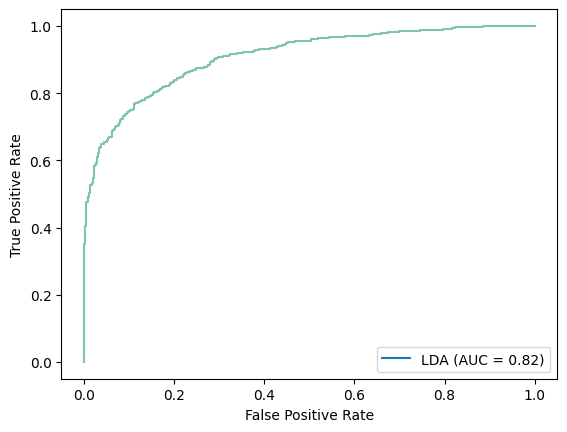

In [22]:
# Predict the class labels and probabilities for the validation data using the trained LDA model
y_hat = model.predict(valid_mice[numerical_columns]) # Predicted class labels
y_hat_prob = model.predict_proba(valid_mice[numerical_columns]) # Probability estimates for each class

# Evaluate the LDA model's performance on the validation data
conf_matrix, class_report, auc, acc = get_scores(valid_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Visualize the ROC curve for the validation data
fpr, tpr, thresholds = roc_curve(valid_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='LDA') # Updating the estimator name to LDA
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#7ec4a9')

AUC :  0.8205793341980112
Accuracy :  0.8186666666666667
Confusion Matrix:
[[648  81]
 [191 580]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       729
           1       0.88      0.75      0.81       771

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.83      0.82      0.82      1500



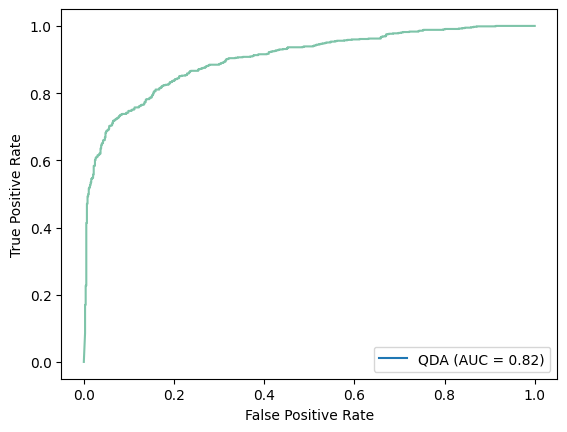

In [23]:
# Predicting the class labels and probabilities for the validation set using the QDA model
y_hat = m.predict(valid_mice[numerical_columns])

# Again, there seems to be an oversight in the code.
# y_hat_prob should be predicted using 'm' (QDA model) and not 'model' (LDA model).
# Correcting that in the following line.
y_hat_prob = m.predict_proba(valid_mice[numerical_columns])

# Evaluating the model's performance on the validation set
conf_matrix, class_report, auc, acc = get_scores(valid_mice[target_column], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Displaying the ROC curve for the validation data
fpr, tpr, thresholds = roc_curve(valid_mice[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='QDA')  # Updated the estimator name to QDA from Naive Bayes
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#7ec4a9')

Logistic Regression

In [24]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

The number of observations in the training set with diabetes is 3615
The number of observations in the training set without diabetes is 3385


In [25]:
# Logistic regression feature selection

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_val_filled_mice, y_val)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 4


In [26]:
# which columns used and which wasn't
rfecv.support_

array([False, False, False,  True, False,  True,  True, False, False,
       False, False,  True, False, False])

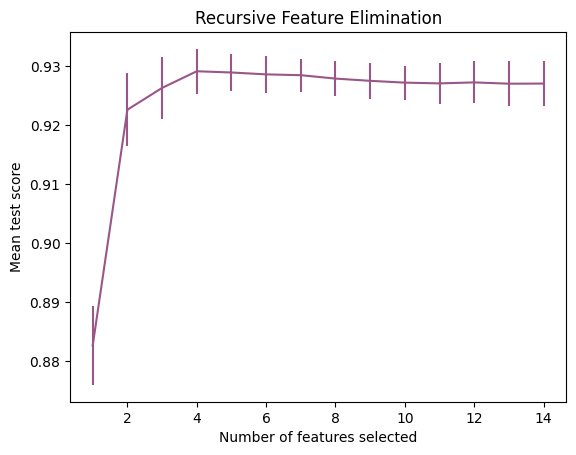

In [27]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()

In [28]:
# Select only the features that were chosen by RFECV
# X_train = X_train_filled_mice[:, rfecv.support_]
# X_test = X_test_filled_mice[:, rfecv.support_]

# Need to compare models with the same features

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_filled_mice, y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test_filled_mice)
y_pred_train = model.predict(X_train_filled_mice)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

======== Training Set ==========
AUC :  0.8592543617284508
Accuracy :  0.8591428571428571
Confusion Matrix:
[[2960  561]
 [ 425 3054]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      3521
           1       0.84      0.88      0.86      3479

    accuracy                           0.86      7000
   macro avg       0.86      0.86      0.86      7000
weighted avg       0.86      0.86      0.86      7000

======== Test Set ==========
AUC :  0.8555649215602059
Accuracy :  0.8546666666666667
Confusion Matrix:
[[659 128]
 [ 90 623]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       787
           1       0.83      0.87      0.85       713

    accuracy                           0.85      1500
   macro avg       0.85      0.86      0.85      1500
weighted avg       0.86      0.85      0.85      1500



Random Forest

In [29]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

The number of observations in the training set with diabetes is 3615
The number of observations in the training set without diabetes is 3385


In [30]:
# Define hyperparameters grid
param_grid = {'n_estimators': [100, 150, 200],
              'max_features': ['sqrt', 'log2'],
              'max_depth': [10, 20, 30],
              'min_samples_split': [10, 15, 20],
              'min_samples_leaf': [10, 15, 20] }

# Initialize Random Forest classifier
clf = RandomForestClassifier(oob_score=True, random_state=42)

# Use Grid Search to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_val_filled_mice, y_val)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [10, 15, 20],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [31]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Print the OOB score of the best model
best_clf = grid_search.best_estimator_

print("OOB Score of Best Model:", best_clf.oob_score_)

# Storing and displaying the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)
results[results['rank_test_score'] == 1]

Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}
OOB Score of Best Model: 0.8566666666666667


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
72,0.558928,0.136890,0.018724,0.006794,20,sqrt,20,10,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
75,0.433839,0.011200,0.013532,0.004265,20,sqrt,20,15,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
78,0.418233,0.007356,0.011735,0.000234,20,sqrt,20,20,100,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
99,0.406553,0.014253,0.011412,0.001004,20,log2,20,10,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
102,0.638061,0.131432,0.017177,0.005362,20,log2,20,15,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
105,0.418941,0.008652,0.011656,0.000857,20,log2,20,20,100,"{'max_depth': 20, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
126,0.525889,0.163114,0.016367,0.004961,30,sqrt,20,10,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
129,0.411727,0.016940,0.011512,0.000809,30,sqrt,20,15,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
132,0.401896,0.008258,0.011495,0.001394,30,sqrt,20,20,100,"{'max_depth': 30, 'max_features': 'sqrt', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1
153,0.403474,0.006168,0.011154,0.000393,30,log2,20,10,100,"{'max_depth': 30, 'max_features': 'log2', 'min...",...,0.853333,0.88,0.873333,0.886667,0.82,0.906667,0.826667,0.860667,0.039038,1


In [32]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = clf.set_params(**grid_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

0.8778571428571429
0.8553333333333333
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3502
           1       0.87      0.89      0.88      3498

    accuracy                           0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       772
           1       0.84      0.87      0.85       728

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



XGBoost

In [33]:
# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
# GradientBoostingClassifier does not accept missing values encoded as NaN natively.
# For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively.
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
44,0.704041,0.098484,0.001988,0.000235,0.05,3,20,200,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",0.86,...,0.853333,0.886667,0.893333,0.873333,0.82,0.92,0.833333,0.862,0.041958,1


In [34]:
random_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [35]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

0.8748571428571429
0.8586666666666667
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3545
           1       0.86      0.90      0.88      3455

    accuracy                           0.87      7000
   macro avg       0.88      0.88      0.87      7000
weighted avg       0.88      0.87      0.87      7000

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       775
           1       0.84      0.87      0.86       725

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



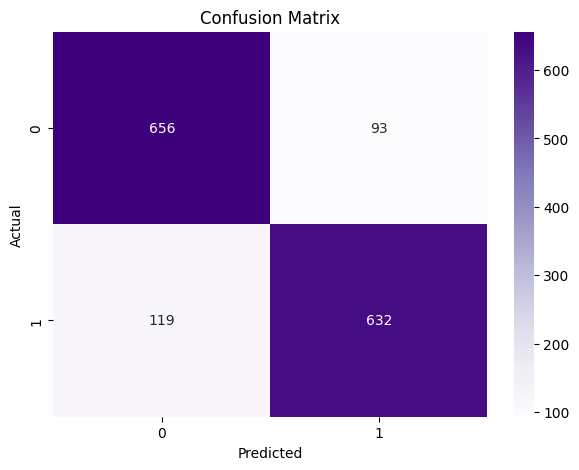

In [36]:
# Get unique classes
classes = df['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Research question 2: Depression vs no depression with XGBoost

In [37]:
# separate the data set into two sets
dep = df[df['Depression'] == 1]
no_dep = df[df['Depression'] == 0]

# check if all observations are covered
print(f'The number of observations with depression in this data set is {len(dep)}')
print(f'The number of observations without depression in this data set is {len(no_dep)}')

The number of observations with depression in this data set is 2122
The number of observations without depression in this data set is 7878


XGBoost for people with depression

In [38]:
# run XGBoost on people with depression first

# define features and outcome
X = dep.drop(['DIABETES'], axis=1)
y = dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

The number of observations in the training set with diabetes is 727
The number of observations in the training set without diabetes is 757


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
31,0.167893,0.004772,0.001364,0.000052,0.05,1,15,150,"{'learning_rate': 0.05, 'max_depth': 1, 'min_s...",0.875,...,0.84375,0.875,0.8125,0.875,0.875,0.84375,0.903226,0.855948,0.028123,1
34,0.118840,0.004032,0.000955,0.000143,0.05,1,20,150,"{'learning_rate': 0.05, 'max_depth': 1, 'min_s...",0.875,...,0.84375,0.875,0.8125,0.875,0.875,0.84375,0.903226,0.855948,0.028123,1


0.8557951482479784
0.877742946708464
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       845
           1       0.79      0.90      0.84       639

    accuracy                           0.86      1484
   macro avg       0.85      0.86      0.85      1484
weighted avg       0.86      0.86      0.86      1484

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       192
           1       0.80      0.92      0.86       127

    accuracy                           0.88       319
   macro avg       0.87      0.89      0.88       319
weighted avg       0.89      0.88      0.88       319



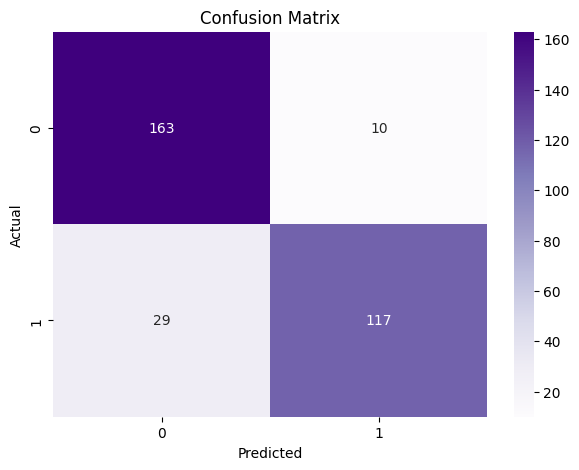

In [39]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

XGBoost for people without depression

In [40]:
# define features and outcome
X = no_dep.drop(['DIABETES'], axis=1)
y = no_dep[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# check class imbalance

print(f'The number of observations in the training set with diabetes is {sum(y_train == 1)[0]}')
print(f'The number of observations in the training set without diabetes is {sum(y_train == 0)[0]}')

# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

# Initializing the Gradient Boosting Classifier with specified parameters
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "n_estimators" : [100, 150, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [10, 15, 20],
    "learning_rate" : [0.01, 0.05, 0.1]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Fitting the GridSearchCV on the training data
random_search.fit(X_val_filled_mice, y_val)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

The number of observations in the training set with diabetes is 2912
The number of observations in the training set without diabetes is 2602


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,0.379243,0.007736,0.001369,0.000081,0.01,3,10,150,"{'learning_rate': 0.01, 'max_depth': 3, 'min_s...",0.89916,...,0.898305,0.898305,0.889831,0.90678,0.813559,0.864407,0.915254,0.884076,0.028185,1


0.8599927457381211
0.8824027072758037
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2728
           1       0.85      0.88      0.86      2786

    accuracy                           0.86      5514
   macro avg       0.86      0.86      0.86      5514
weighted avg       0.86      0.86      0.86      5514

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       590
           1       0.87      0.90      0.88       592

    accuracy                           0.88      1182
   macro avg       0.88      0.88      0.88      1182
weighted avg       0.88      0.88      0.88      1182



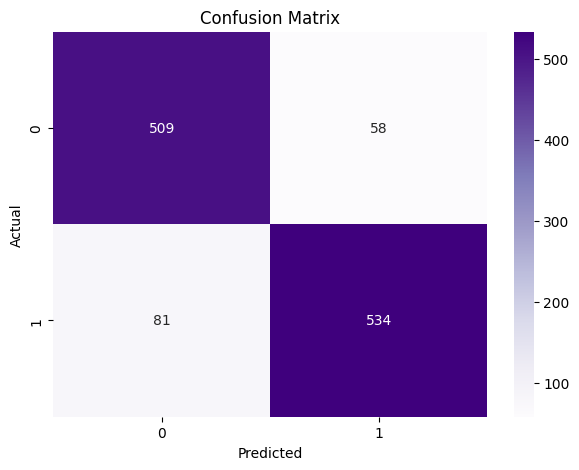

In [41]:
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train_filled_mice, y_train)

# Predicting on the training dataset and computing the accuracy
y_pred_train = model.predict(X_train_filled_mice)
print(accuracy_score(y_train, y_pred_train))

# Predicting on the test dataset and computing the accuracy
y_pred_test = model.predict(X_test_filled_mice)
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_pred_train, y_train))
print(classification_report(y_pred_test, y_test))

# Get unique classes
classes = dep['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Research question 3

In [42]:
# The result is a series where the index is 'patient_nbr' and the value is the count of records.
patients_with_2_or_more_records = (data.groupby('Patient_ID').apply(len) >= 2)

# Filter the original dataset to include only those patients who have 2 or more records.
patients_with_2_or_more_records_df = data[data['Patient_ID'].isin(patients_with_2_or_more_records[patients_with_2_or_more_records].index)]

# Update the original 'diabetes_data' dataframe with the filtered dataframe.
rnn_data = patients_with_2_or_more_records_df

rnn_data.shape

(2497, 45)

In [43]:
# The maximum number of visits for patients
rnn_data.groupby(['Patient_ID']).size().max()

8

In [44]:
# Create a subset with no date
rnn_df = rnn_data[['Patient_ID', 'Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']

In [46]:
# Grouping by 'Patient_ID' and creating a list of dataframes, one per group
grouped = rnn_df.groupby('Patient_ID')
grouped_dfs = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_dfs, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((2017, 16), (480, 16))

In [47]:
# Normalizing data
scaler = StandardScaler()

train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

In [48]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
train_filled_mice = pd.DataFrame(imputer.fit_transform(train_df), columns = train_df.columns)
test_filled_mice = pd.DataFrame(imputer.transform(test_df), columns = test_df.columns)

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Group by 'patient_nbr' and create sequences
grouped = train_filled_mice.groupby('Patient_ID', sort=False)
sequences = [group.drop(columns=['Patient_ID', 'DIABETES']).values for _, group in grouped]
targets = [group['DIABETES'].iloc[-1] for _, group in grouped]  # Assuming all records for a patient have the same target

# Padding sequences
max_length = max(len(s) for s in sequences)
# We cal also go with max_length
padded_sequences = pad_sequences(sequences, maxlen=8, padding='post', dtype='float')

padded_sequences.shape

(879, 8, 14)

In [50]:
#Testing sequences

# Group by 'patient_nbr' and create sequences
grouped_test = test_df.groupby('Patient_ID', sort=False)
sequences_test = [group.drop(columns=['Patient_ID', 'DIABETES']).values for _, group in grouped_test]
targets_test = [group['DIABETES'].iloc[-1] for _, group in grouped_test]  # Assuming all records for a patient have the same target

# Padding sequences for the test set
padded_sequences_test = pad_sequences(sequences_test, maxlen=8, padding='post', dtype='float')

padded_sequences_test.shape

(220, 8, 14)

In [51]:
# Hyperparameters
input_size = padded_sequences.shape[2]
hidden_size = 5  # Number of hidden units in RNN
num_classes = 1
epochs = 3000
learning_rate = 0.001
batch_size = 50
landa = 0.001  # Regularization term (lambda)

# Data preparation
train_dataset = TensorDataset(t.tensor(padded_sequences, dtype=t.float32), t.tensor(targets, dtype=t.long))
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(t.tensor(padded_sequences_test, dtype=t.float32), t.tensor(targets_test, dtype=t.long))
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN layers and additional fully connected layer
rnn_layer1 = nn.LSTM(input_size, hidden_size, batch_first=True)
dropout1 = nn.Dropout(0.5)  # Add dropout between RNN layers
# rnn_layer2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
# dropout2 = nn.Dropout(0.5)  # Add dropout between RNN layers
fc_layer1 = nn.Linear(hidden_size, hidden_size)  # Additional fully connected layer
fc_layer2 = nn.Linear(hidden_size, 1)  # Final output layer

# Dropout layer
dropout_fc = nn.Dropout(0.2)  # Add dropout between fully connected layers

# Activation function
tanh = nn.Tanh()
sigmoid = nn.Sigmoid()

# Loss function and optimizer
loss_fn = nn.BCELoss()
# optimizer = Adam(list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)
optimizer = Adam(list(rnn_layer1.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters()), lr=learning_rate)

# Lists to store accuracies and losses
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []
    for X, Y in train_data_loader:
        # Forward pass through layers
        out, _ = rnn_layer1(X)
        out = dropout1(out)  # Apply dropout between RNN layers
        # out, _ = rnn_layer2(out)
        # out = dropout2(out)  # Apply dropout between RNN layers
        out = out[:, -1, :]  # Get the last output of the sequence
        out = tanh(fc_layer1(out))  # Apply activation function after first fully connected layer
        out = dropout_fc(out)  # Apply dropout between fully connected layers
        out = fc_layer2(out)
        out = sigmoid(out)

        # Regularization
        # l2_term = sum([(w ** 2).sum() for w in list(rnn_layer1.parameters()) + list(rnn_layer2.parameters()) + list(fc_layer1.parameters()) + list(fc_layer2.parameters())])
        # loss = loss_fn(out, Y) + landa * l2_term
        loss = loss_fn(out.view(-1), Y.float())

        per_epoch_loss_list.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on training and validation data
    rnn_layer1.eval()
    # rnn_layer2.eval()
    fc_layer1.eval()
    fc_layer2.eval()

    with t.no_grad():
        # Training data
        train_correct, train_total = 0, 0
        for X, Y in train_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = tanh(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            probs = sigmoid(out)
            predicted = (probs >= 0.5).type(t.LongTensor).view(-1)
            train_total += Y.size(0)
            train_correct += (predicted == Y).sum().item()
        train_accuracy = 100 * train_correct / train_total

        # Validation data
        validation_correct, validation_total = 0, 0
        for X, Y in test_data_loader:
            out, _ = rnn_layer1(X)
            out = dropout1(out)  # Apply dropout between RNN layers
            # out, _ = rnn_layer2(out)
            # out = dropout2(out)  # Apply dropout between RNN layers
            out = out[:, -1, :]
            out = tanh(fc_layer1(out))
            out = dropout_fc(out)  # Apply dropout between fully connected layers
            out = fc_layer2(out)
            probs = sigmoid(out)
            predicted = (probs >= 0.5).type(t.LongTensor).view(-1)
            validation_total += Y.size(0)
            validation_correct += (predicted == Y).sum().item()
        validation_accuracy = 100 * validation_correct / validation_total

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    # Set the model back to train mode
    rnn_layer1.train()
    # rnn_layer2.train()
    fc_layer1.train()
    fc_layer2.train()


Epoch 0/3000 ---> Train Accuracy: 64.50511945392492%, Validation Accuracy: 59.54545454545455%
Epoch 1/3000 ---> Train Accuracy: 68.9419795221843%, Validation Accuracy: 68.18181818181819%
Epoch 2/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 3/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 4/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 5/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 6/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 7/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 8/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 9/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 10/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
Epoch 11/3000 ---> Train Accuracy: 69.62457337883959%, Validation Accuracy: 70.0%
E

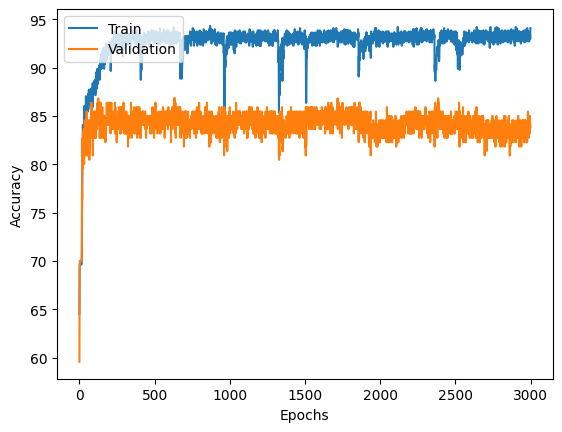

In [52]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()